# Understanding Large Language Models : Stocks and Sentiments

by Krishaant Pathmanathan, Yash Mali, Nathan Zhanng

In [8]:
# pip install yfinance finvizfinance transformers pandas numpy statsmodels holidays plotly ipywidgets 

In [49]:
# Installing the packages we need to run this notebook 
import yfinance as yf
from finvizfinance.quote import finvizfinance
from transformers import pipeline
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import holidays
import plotly.graph_objects as go
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns 
import warnings
import os
import glob




## What do Large Language Models do?

Large language models like ChatGPT do something that seems very simple: **Next word prediction.**

What does that mean? It means that given a sequence of words, the model predicts the next word in the sequence. For example, if the input is "The cat sat on the", the model might predict "mat" as the next word.

![](images/next_word_prediction.png)

We saw an example of predicting just one word. These models predict only one word at a time, but they can do this for very long sequences of words.

For example: "bob went to the store" to buy some milk.

![](images/sequence_words.png)

What the model is doing is learning the probability distribution of the next word given the previous words.

The probability of predicting the next word $w_{t}$ given the previous words $w_1, w_2, \ldots, w_{t-1}$ is:

$$
P(w_t \mid w_1, w_2, \ldots, w_{t-1}) = \frac{P(w_1, w_2, \ldots, w_{t-1}, w_t)}{P(w_1, w_2, \ldots, w_{t-1})}
$$

LLMs approximate this probability:

$$
P(w_t \mid w_1, w_2, \ldots, w_{t-1})
$$

The model predicts the next word by choosing the word that, based on everything so far, seems the most likely to come next. The word $w_t$ that maximizes this conditional probability:

$$
\hat{w}_t = \arg\max_{w} P(w \mid w_1, w_2, \ldots, w_{t-1})
$$

These models give a probability distribution over the entire vocabulary (all the words the model was trained on). We can then pick the word with the highest probability as the next word or we can sample from this distribution to get more varied (creative) outputs.

Lets look at an example of how this works in practice:


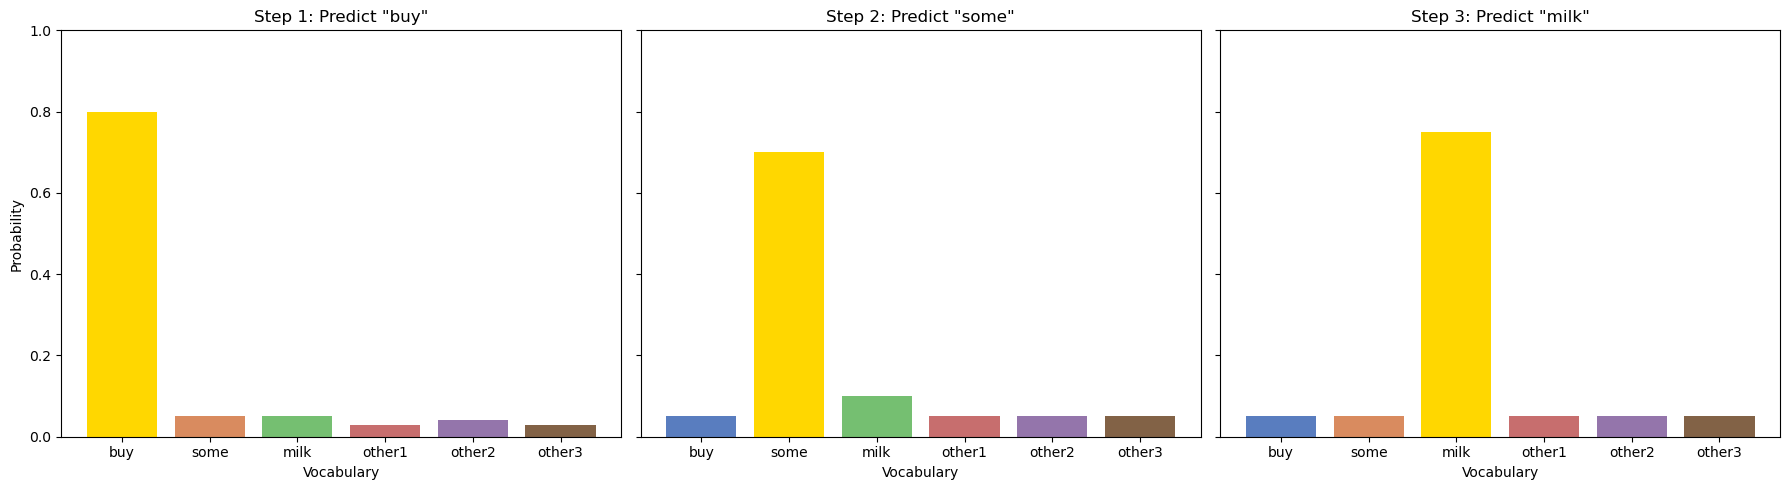

In [19]:
warnings.filterwarnings("ignore")

# Example vocabulary
vocab = ['buy', 'some', 'milk', 'other1', 'other2', 'other3']

# Probabilities at each step (toy example)
probs_step1 = [0.8, 0.05, 0.05, 0.03, 0.04, 0.03]  # 'buy' high
probs_step2 = [0.05, 0.7, 0.1, 0.05, 0.05, 0.05]   # 'some' high
probs_step3 = [0.05, 0.05, 0.75, 0.05, 0.05, 0.05] # 'milk' high

prob_distributions = [probs_step1, probs_step2, probs_step3]
step_labels = ['Step 1: Predict "buy"', 'Step 2: Predict "some"', 'Step 3: Predict "milk"']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axes):
    sns.barplot(x=vocab, y=prob_distributions[i], palette='muted', ax=ax)
    ax.set_title(step_labels[i])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability' if i == 0 else '')
    ax.set_xlabel('Vocabulary')
    # Highlight the max prob bar in gold
    max_idx = prob_distributions[i].index(max(prob_distributions[i]))
    ax.bar(max_idx, prob_distributions[i][max_idx], color='gold')

plt.tight_layout()
plt.show()

To get more creative responses you change the distribution at the output where you pick the next word. Very simply this involves making the distribution sharper or flatter.
If you make the distribution sharper, you are more likely to pick the word with the highest probability. If you make it flatter, you are more likely to pick a word that is not the most probable one.

This is called **temperature**. A higher temperature makes the distribution flatter, while a lower temperature makes it sharper. You would want to use a temperature of more than 1 $(1.2-1.5)$ for creative responses, and a temperature of less than 1 $(0.1 - 0.5)$ for more focused responses. For a balanced response, you can use a temperature of $0.7-1$.
Another set of parameters are called top-p and top-k sampling.

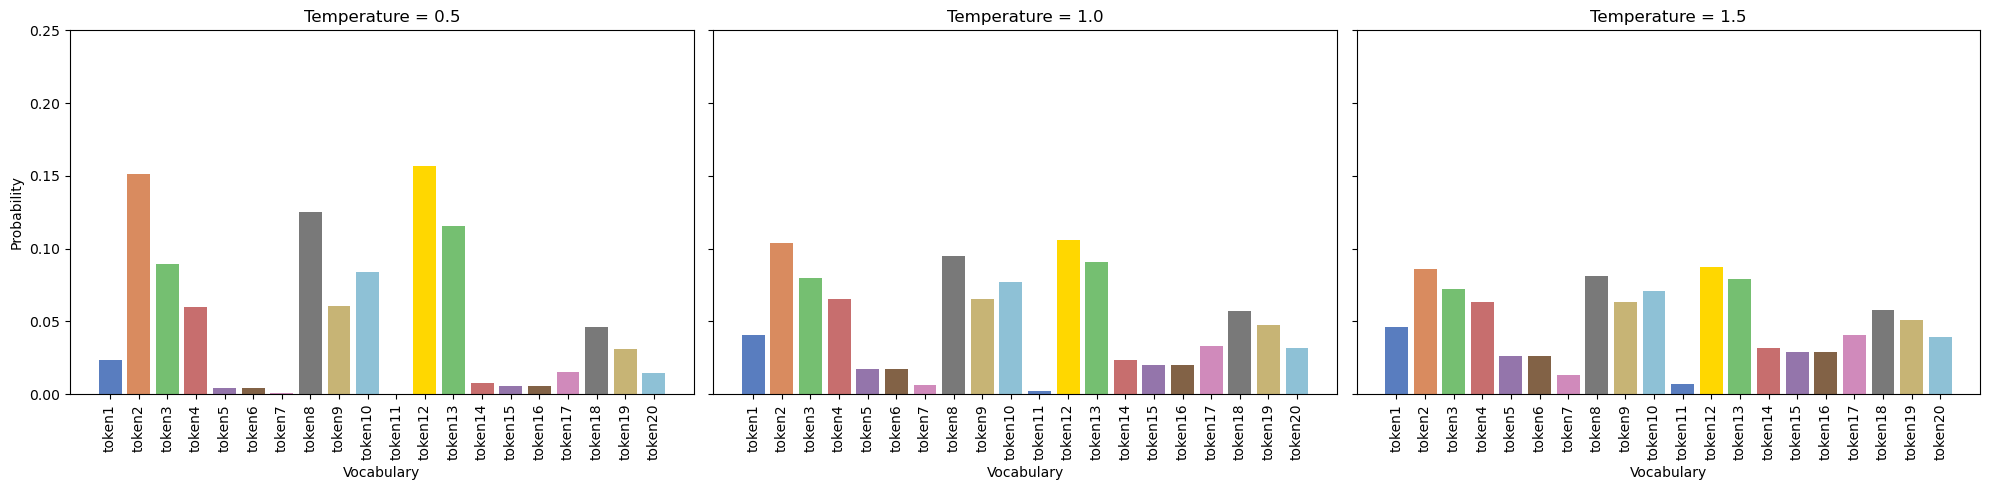

In [20]:
warnings.filterwarnings("ignore")

np.random.seed(42)
vocab_size = 20
vocab = [f'token{i}' for i in range(1, vocab_size+1)]
base_probs = np.random.rand(vocab_size)
base_probs /= base_probs.sum()  # Normalize to sum to 1

def apply_temperature(probs, temp):
    logits = np.log(probs + 1e-20)
    scaled_logits = logits / temp
    exp_logits = np.exp(scaled_logits)
    return exp_logits / exp_logits.sum()

temperatures = [0.5, 1.0, 1.5]
distributions = [apply_temperature(base_probs, t) for t in temperatures]

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
for i, (ax, dist, temp) in enumerate(zip(axes, distributions, temperatures)):
    sns.barplot(x=vocab, y=dist, palette='muted', ax=ax)
    ax.set_title(f'Temperature = {temp}')
    ax.set_ylim(0, 0.25)
    ax.set_ylabel('Probability' if i == 0 else '')
    ax.set_xlabel('Vocabulary')
    ax.tick_params(axis='x', rotation=90) # Rotate x-axis labels
    max_idx = dist.argmax()
    ax.bar(max_idx, dist[max_idx], color='gold')

plt.tight_layout()
plt.show()

In the example above, we see how the probability distribution changes with different temperatures. A high temperature (1.5) results in a flatter distribution, meaning the model is more likely to sample from less probable tokens, while a low temperature (0.5) results in a sharper distribution, favoring the most probable tokens.

Note that while this is with words and language, the same idea applies to any sequential data, like stock prices, weather data, etc. The model looks at what happened before and tries to guess what comes next.

If you are interested in understanding the inner workings of these models, take a look at the interactive visualization at [The Illustrated Transformer](https://poloclub.github.io/transformer-explainer/) . It provides an excellent, hands-on way to explore the core ideas behind modern language models.


So, just like it guesses the next word in a sentence, it can guess the next day’s temperature or the next movement in a stock price, based on the pattern it sees in the earlier numbers. 

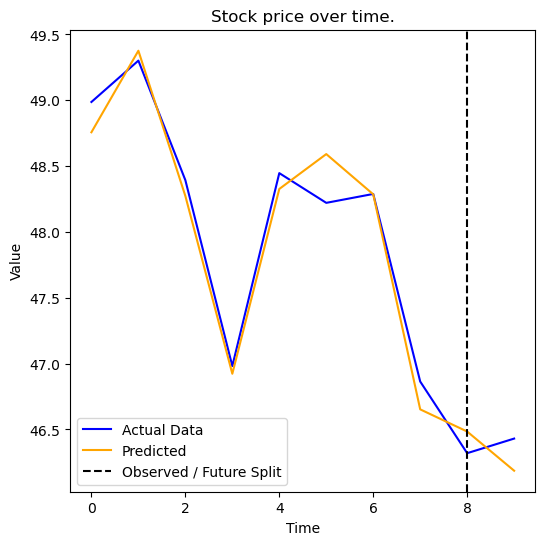

In [21]:
n = 10
m = 9

# Generate actual data: random walk + small trend
actual_data = np.cumsum(np.random.normal(0, 1, n)) + 50

# Predictor approximates entire data closely with small noise everywhere
predicted = actual_data + np.random.normal(0, 0.2, n)

# Posterior uncertainty: low and roughly constant over entire period
posterior_std = np.full(n, 0.3)

upper = predicted + posterior_std
lower = predicted - posterior_std

plt.figure(figsize=(6,6))
plt.plot(range(n), actual_data, label="Actual Data", color='blue')
plt.plot(range(n), predicted, label="Predicted", color='orange')
plt.axvline(x=m-1, color='black', linestyle='--', label="Observed / Future Split")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Stock price over time.")
plt.legend()
plt.show()

Typically, when building a model to predict stock prices, you would use more information than just the past prices. For example, you might include things like public sentiment (how people feel about the stock), news headlines, or other features that could influence the price.

In the examples below, that's exactly what we're going to try! We'll see how adding these extra features can help the model make better predictions about what happens next.

# Predicting Stock Prices from News Headlines with AI

Just like LLMs predict the next word based on the context of prior words:

$$
P(w_t \mid w_1, w_2, \ldots, w_{t-1})
$$

We can use similar models to predict the next value in a time series, like **stock prices** or **percentage changes** in returns.

But instead of words, our "tokens" are **daily stock returns**, and instead of using a pure language context, we enrich our prediction using **public sentiment** extracted from news headlines.

Comparing word and stock price prediction 

| Word Prediction                   | Stock Price Prediction           |
|-------------------------------------|--------------------------------------|
| Previous words                      | Previous stock returns               |
| Next word prediction                | Future return prediction             |
| Attention to important words        | Weight on news sentiment  |
| Temperature to control randomness   | Confidence intervals in forecasts    |
| Word probability distribution       | Forecasted return distribution       |

In this case study, we use a language model to analyze real-time news headlines alongside historical stock prices in order to forecast short-term changes in stock value.

You’ll:
- Collect news headlines about real companies (like Amazon or Starbucks)
- Use a pre-trained AI model to classify the **sentiment** (positive or negative) of these news headlines
- Combine that with stock prices
- Use a forecasting model to predict future price changes
- Visualize your results interactively


## Preview the News Data

Here we use the `finvizfinance` packages to retrive real-time news headlines for companies like Starbucks (SBUX).


In [23]:
# The code below will give us a snapshot of the 100 most recent news headlines for a particular stock in the last 30 days.  

def get_news_data(ticker):
    stock = finvizfinance(ticker)
    news_df = stock.ticker_news()
    news_df = pd.DataFrame(news_df)

    # Drop NaN and clean whitespace
    news_df = news_df.dropna(subset=["Title"])
    news_df = news_df[news_df["Title"].str.strip() != ""]
    news_df['Title'] = news_df['Title'].str.lower()
    news_df['Date'] = pd.to_datetime(news_df['Date'])
    news_df['DateOnly'] = news_df['Date'].dt.date
    news_df["Ticker"] = ticker.upper()
    # Remove the 'Date' column
    news_df = news_df.drop(columns=['Date'])

    return news_df.reset_index(drop=True)

# For the sake of reproducability (so we always get the same results), we will use a a dataset that was scrapped using the same method at an earlier time (July - 2025)

# Uncomment the line below get a more recent snapshot of the data ! 
# SBUX_news_df = get_news_data("SBUX")
# SBUX_news_df.to_csv("data/SBUX_news.csv", index=False)


Let’s look at what the cleaned news data looks like. We’ll start with Starbucks (`SBUX`).

Each row is a headline, what website it was from, the date it was published and a ticker indicating what stock it is for. 

In [24]:
SBUX_news_df = pd.read_csv("data/SBUX_news.csv")
SBUX_news_df.head()

,Title,Link,Source,DateOnly,Ticker
0,"jim cramer on starbucks: ""i think it was a ver...",/news/125467/jim-cramer-on-starbucks-i-think-i...,Insider Monkey,2025-08-02,SBUX
1,starbucks ceo talks rising coffee prices and t...,https://finance.yahoo.com/video/starbucks-ceo-...,Yahoo Finance Video,2025-08-01,SBUX
2,"the best way to see china? on futuristic, punc...",https://finance.yahoo.com/m/8ada9915-5a7b-3888...,The Wall Street Journal,2025-08-01,SBUX
3,wall street circles starbucks as china deal he...,https://finance.yahoo.com/news/wall-street-cir...,GuruFocus.com,2025-08-01,SBUX
4,"starbucks, cava, shake shack, bloomin' brands,...",/news/125185/starbucks-cava-shake-shack-bloomi...,StockStory,2025-08-01,SBUX


## Classifying Headline Sentiment with LLM

Earlier, we explored how **large language models (LLMs)** predict the *next word* by learning the probability distribution of possible outcomes based on context.

Now, we apply a similar idea to **entire sentences** — in this case, financial news headlines. Instead of predicting the next word, the model assigns a probability to each **sentiment category** (e.g. POSITIVE, NEGATIVE, or NEUTRAL).

#### How it works:
- A pre-trained model reads the headline.
- It assigns probabilities to the sentiment labels.
- We keep only **positive** or **negative** headlines, since those are more likely to affect stock prices.
  
This is like asking:
> *Given the words in this sentence, what is the most likely emotion behind it?*

We use Hugging Face’s `pipeline()` function to load a **DistilBERT** model — a lighter version of the BERT model trained to understand the tone of text. Although it was originally trained on movie reviews, it generalizes well and works surprisingly well on financial headlines too!

This builds directly on our earlier discussion of LLMs predicting **probability distributions**, but here, the prediction is over **sentiment classes** rather than words.

We now apply a pre-trained **large language model** to each headline.

It returns:
- `POSITIVE` — news that sounds good (e.g., “profits surge”)
- `NEGATIVE` — news that sounds bad (e.g., “lawsuit filed”)

> *Can you think of a positive and negative news headline ?*

We skip `NEUTRAL` news to focus on strong market signals.

In this case, we apply a pre-trained LLM called **Twitter-RoBERTa**, specifically trained on tweets and social media text. It’s well-suited to handling short, informal writing — like news headlines.



In [17]:
# Here we are just specifying the classifier (AI model) that decides on a sentiment 

classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=-1)

# define a function to classify sentiment of each text 
def classify_sentiment(text):
    return classifier(text)[0]["label"].upper()

# define classify_sentiment to entire dataframe
def apply_sentiment(news_df):
    news_df["Sentiment"] = news_df["Title"].apply(classify_sentiment)
    return news_df # [news_df["Sentiment"] != "NEUTRAL"] # remove neutral headlines

def process_sentiment(news_df):
    grouped = news_df.groupby(["DateOnly", "Sentiment"]).size().unstack(fill_value=0)
    grouped = grouped.reindex(columns=["POSITIVE", "NEGATIVE"], fill_value=0)
    # Calculate a rolling 7-day total of positive headlines
    grouped["7day_avg_positive"] = grouped["POSITIVE"].rolling(window=7, min_periods=1).sum()
    # Calculate a rolling 7-day total of negative headlines
    grouped["7day_avg_negative"] = grouped["NEGATIVE"].rolling(window=7, min_periods=1).sum()
    # Calculate the percentage of positive headlines each day (out of total positive + negative)
    grouped["7day_pct_positive"] = grouped["POSITIVE"] / (grouped["POSITIVE"] + grouped["NEGATIVE"])

    return grouped.reset_index()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Lets use our model to see wether the sentence "I hate bananas" is negative or positive 

>*Try changing the words inside classify sentiment to see wether its is classified positive or negative*

In [29]:
classify_sentiment("I hate bananas")        # You can change the words inside the function to test anything you want! 

'NEGATIVE'

### 💡 Engage Critically: Sentiment Analysis in Economics

> Sentiment analysis is often used to gauge market confidence, consumer optimism, or political risk. It treats online language as a proxy for economic behavior. But we know that economic indicators are deeply shaped by policy, culture, and collective narratives—not just by measurable sentiment.
>
> Many economic sentiment indices (like consumer confidence or “fear/greed” indexes) assume that expressed sentiment directly translates to real-world spending, investment, or risk-taking. In reality, these links can be **indirect, lagged, or culturally biased**: people may express pessimism online but keep spending, or express optimism while privately bracing for risk. It’s like when you tweet: “I am so broke” but continue to buy Labubus. 
>
>> ❓ **Consider:** Who is represented in your dataset? Do these news headlines really reflect the actual economic actors (investors, business owners, households) ?
>
>> ❓ **Ask yourself:** Are there structural, cultural, or platform-specific biases shaping whose economic “sentiment” you’re measuring? How might your results look different for another country's stock market ?
>
> If you’re interested, check out [this short article](https://cepr.org/voxeu/columns/twitter-sentiment-and-stock-market-movements-predictive-power-social-media) from VoxEU on how Twitter sentiment and stock market movements.

Now let's apply this to our entire `SBUX_news_df` and see how each news headline is classified. 

In [30]:
news_df = apply_sentiment(SBUX_news_df)       # Classify sentiment of each Starbucks news headline
news_df.head()

,Title,Link,Source,DateOnly,Ticker,Sentiment
0,"jim cramer on starbucks: ""i think it was a ver...",/news/125467/jim-cramer-on-starbucks-i-think-i...,Insider Monkey,2025-08-02,SBUX,POSITIVE
1,starbucks ceo talks rising coffee prices and t...,https://finance.yahoo.com/video/starbucks-ceo-...,Yahoo Finance Video,2025-08-01,SBUX,NEUTRAL
2,"the best way to see china? on futuristic, punc...",https://finance.yahoo.com/m/8ada9915-5a7b-3888...,The Wall Street Journal,2025-08-01,SBUX,POSITIVE
3,wall street circles starbucks as china deal he...,https://finance.yahoo.com/news/wall-street-cir...,GuruFocus.com,2025-08-01,SBUX,NEUTRAL
4,"starbucks, cava, shake shack, bloomin' brands,...",/news/125185/starbucks-cava-shake-shack-bloomi...,StockStory,2025-08-01,SBUX,NEGATIVE


Lets summarize the sentiment results by date. For each day we count the number of positive and negative headlines, then calculate 7-day moving averages and the daily percentage of positive news. This gives us a quick overview of news sentiment trends over time.

In [27]:
sentiment_df = process_sentiment(news_df)       # Summarize daily sentiment statistics
sentiment_df.head()                             # Display the first 5 rows of the dataframe

Sentiment,DateOnly,POSITIVE,NEGATIVE,7day_avg_positive,7day_avg_negative,7day_pct_positive
0,2025-07-29,7,5,7.0,5.0,0.583333
1,2025-07-30,8,6,15.0,11.0,0.571429
2,2025-07-31,3,1,18.0,12.0,0.750000
3,2025-08-01,2,1,20.0,13.0,0.666667
4,2025-08-02,1,0,21.0,13.0,1.000000


###  What This Table Shows
This table is the **output of a function that summarizes news sentiment over time**.

Each row corresponds to a specific **date** and gives us a snapshot of how positive or negative the news headlines were for that day and the surrounding week.



Markets move not just based on today's headlines, but on **short-term trends** in public sentiment.  
This table lets us track how optimism or pessimism is **building up over time**, which we can later use to help predict stock price movements.

###  Why is this useful?
- We know that in the last 100 news stories about NVDIA 24 have been positive and 5 have been negative. 
- If the `7day_pct_positive` is rising, the **overall tone of news** is getting more optimistic.
- If it's dropping, it could mean **public or investor concern** is growing.
- We can later **plot this** and compare it against stock price to see if sentiment influences market behavior.

## Getting Stock Price Data 

We're using the `yfinance` package to get **real stock price data** directly from Yahoo Finance. The function below helps us **download historical stock prices** and compute the **daily percentage change** in the stock's closing price. To make sure our results are replicaable, this data has been saved as a csv "data/NVDA_snapshot.csv"

This allows us to analyze how stock prices change over time.


In [36]:
# The code below will give us a snapshot of stock prices for the duration in we have news headlines for.  

def get_stock_data(ticker, start, end):
    stock = yf.download(ticker, start=start, end=end)

    # Flatten columns if multi-indexed (e.g., multiple tickers)
    if isinstance(stock.columns, pd.MultiIndex):
        stock.columns = ['_'.join(col).strip() for col in stock.columns]  # "Close_SBUX", etc.
        close_col = f"Close_{ticker}"
    else:
        close_col = "Close"

    stock["Pct_Change"] = stock[close_col].pct_change() * 100
    stock.reset_index(inplace=True)
    stock["DateOnly"] = pd.to_datetime(stock["Date"])
    return stock[["DateOnly", "Pct_Change"]]

# merges sentiment and stock data by date, and lags sentiment by one day to align with price changes.
def combine_data(sent_df, stock_df):
    sent_df = sent_df.reset_index(drop=True)
    stock_df = stock_df.reset_index(drop=True)

    sent_df["DateOnly"] = pd.to_datetime(sent_df["DateOnly"])
    stock_df["DateOnly"] = pd.to_datetime(stock_df["DateOnly"])

    return (
        pd.merge(sent_df, stock_df, on="DateOnly", how="inner")
          .assign(lagged_sentiment=lambda df: df["7day_pct_positive"].shift(1))
    )


# For the sake of reproducability (so we always get the same results), we will use a a dataset that was scrapped using the same method at an earlier time (July - 2025)

# Uncomment the line below get a more recent snapshot of the data ! 

# SBUX_news_df["DateOnly"] = pd.to_datetime(SBUX_news_df["DateOnly"])
# start_date = SBUX_news_df["DateOnly"].min() - pd.Timedelta(days=1) 
# end_date = SBUX_news_df["DateOnly"].max() + pd.Timedelta(days=1) 
# stock_df = get_stock_data("SBUX", start_date, end_date)
# stock_df.to_csv("data/SBUX_price.csv", index=False)

SBUX_price_df = pd.read_csv("data/SBUX_price.csv")
SBUX_price_df.head()


,DateOnly,Pct_Change
0,2025-07-28,NaN
1,2025-07-29,-0.757979
2,2025-07-30,-0.215143
3,2025-07-31,-3.880981
4,2025-08-01,-2.579635


Now we bring together the sentiment summary data and the stock price changes. By merging these two datasets, we can analyze how changes in news sentiment might be related to changes in Starbucks’ stock price. This combined dataset will help us answer the question : “Does positive news sentiment lead to an increase in stock price?” 

In [37]:
combined_df = combine_data(sentiment_df, stock_df)
combined_df

,DateOnly,POSITIVE,NEGATIVE,7day_avg_positive,7day_avg_negative,7day_pct_positive,Pct_Change,lagged_sentiment
0,2025-07-29,7,5,7.0,5.0,0.583333,-0.757979,NaN
1,2025-07-30,8,6,15.0,11.0,0.571429,-0.215143,0.583333
2,2025-07-31,3,1,18.0,12.0,0.750000,-3.880981,0.571429
3,2025-08-01,2,1,20.0,13.0,0.666667,-2.579635,0.750000



### Forecasting Future Stock Changes with Sentiment

We’re now trying to **predict future stock price changes** using the **SARIMAX model**, a powerful forecasting tool that allows us to include **external information** in our case, **public sentiment**. 

Basically this function is asking "Based on recent sentiment, what does the model think will happen to this stock’s price over the next few days?"


In [40]:
# business days we should forecast for 
def get_future_dates(start_date, num_days):
    if not isinstance(start_date, pd.Timestamp):
        start_date = pd.to_datetime(start_date)

    us_holidays = holidays.US()
    future_dates = []
    current_date = start_date + pd.Timedelta(days=1)

    while len(future_dates) < num_days:
        if current_date.weekday() < 5 and current_date.date() not in us_holidays:
            future_dates.append(current_date)
        current_date += pd.Timedelta(days=1)

    return future_dates

# prediction model
def fit_and_forecast(combined_df, forecast_steps=3):
    combined_df = combined_df.dropna(subset=['Pct_Change', 'lagged_sentiment'])

    endog = combined_df['Pct_Change']
    exog = combined_df['lagged_sentiment']

    model = SARIMAX(endog, exog=exog, order=(1, 1, 1))
    fit = model.fit(disp=False)

    future_dates = get_future_dates(combined_df.index[-1], forecast_steps)
    future_exog = np.tile(combined_df['lagged_sentiment'].iloc[-1], forecast_steps).reshape(-1, 1)

    forecast = fit.get_forecast(steps=forecast_steps, exog=future_exog)
    return forecast.predicted_mean, forecast.conf_int(), future_dates

def create_plot(combined_df, forecast_mean, forecast_ci, forecast_index):
    combined_df = combined_df.copy()
    sentiment_std = (combined_df['lagged_sentiment'] - combined_df['lagged_sentiment'].mean()) / combined_df['lagged_sentiment'].std()

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=combined_df.index,
        y=sentiment_std,
        name='Standardized Sentiment',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=combined_df.index,
        y=combined_df['Pct_Change'],
        name='Stock % Change',
        yaxis='y2',
        line=dict(color='green')
    ))

    fig.add_trace(go.Scatter(
        x=forecast_index,
        y=forecast_mean,
        name='Forecasted % Change',
        line=dict(color='red')
    ))

    fig.add_trace(go.Scatter(
        x=np.concatenate([forecast_index, forecast_index[::-1]]),
        y=np.concatenate([forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1][::-1]]),
        fill='toself',
        fillcolor='rgba(255,0,0,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))

    fig.update_layout(
        title='Sentiment vs Stock Change Forecast',
        xaxis_title='Date',
        yaxis=dict(
            title=dict(text='Standardized Sentiment', font=dict(color='blue'))
        ),
        yaxis2=dict(
            title=dict(text='Stock % Change', font=dict(color='green')),
            overlaying='y',
            side='right'
        ),
        template='plotly_dark'
    )

    fig.show()

### Plot: Sentiment vs Stock % Change Forecast

This chart shows how **news sentiment** about a company relates to its **stock price changes** over time, and how we can use this relationship to make simple predictions.

- The **blue line** shows the standardized 7-day average of positive sentiment extracted from financial news headlines. A higher value means news sentiment was more positive.
- The **green line** shows the actual daily percentage change in the company’s stock price.
- The **red line** shows our simple **forecast** of future stock movement based on past sentiment trends. The shaded red area represents uncertainty around the forecast (a 95% confidence interval).

We want to see whether the **emotions in the news** (blue) can help us **predict price changes** (green and red). If they move together, it suggests that public mood might influence investor behavior.

> This plot helps us visualize correlations and test basic forecasting using real-world data like stock prices and media sentiment.


In [39]:
combined_df['DateOnly'] = pd.to_datetime(combined_df['DateOnly'])  # convert to datetime
combined_df.set_index('DateOnly', inplace=True)  # use as index
combined_df.sort_index(inplace=True)  # ensure time order

forecast_mean, forecast_ci, forecast_index = fit_and_forecast(combined_df)
create_plot(combined_df, forecast_mean, forecast_ci, forecast_index)

>  **Disclaimer**: This is a simplified model. In reality, stock prices are influenced by many factors, such as interest rates, earnings reports, geopolitical events, and investor speculation. This chart only considers **one variable**: news sentiment. It should not be used for actual trading decisions.

### 💡 Engage Critically: More than just news headlines !

> Our stock prediction models uses **price history** and **news sentiment** to predict future stock price. But financial markets are influenced by far more than just news and past prices! 
>
> Real-world stock movements are affected by things like **interest rates**, **inflation**, **company earnings**, **supply chain shocks**, **global events**, and even investor “herding” behavior. Market “sentiment” captured from news can miss the underlying economic drivers or be distorted by hype, bots, or selective reporting. Sometimes, big price changes happen for reasons that never make the headlines!
>
>> ❓ **Consider:** If you were building your own predictive model, what other data sources might you want to include to get a fuller picture of what moves stock prices?
>
>> ❓ **Ask yourself:** How would you weigh economic indicators (like unemployment or inflation), company fundamentals (like revenue or debt), or alternative signals (like Google search trends, options market activity, or even weather)?
>

# How do AIs feel about AI?

In this section of the notebook, we explore how our **AI Sentiment Analysis model** feels about **AI-related stocks**. Thats a mouthful ! 

The goal is to see if public sentiment (as captured by the headlines) is generally optimistic or pessimistic toward leading AI companies — as interpreted by another AI (we are using BERT here !).

We'll start by selecting the [top 10 AI stocks in 2025](https://www.forbes.com/advisor/investing/best-ai-stocks/) as suggested by financial news magazine, Forbes
- `ACN` (Accenture)
- `ADBE` (Adobe)
- `AMD` (Advanced Micro Devices)
- `APP` (Applovin)
- `AVGO` (Broadcom)
- `CRM` (Salesforce)
- `MRVL` (Marvell Technology)
- `MU` (Micron Technology)
- `NVDA` (NVIDIA)
- `QCOM` (Qualcomm)

For each company, we'll:
2. Classify the sentiment using our `RoBERTa`-based model
1. Pull recent news headlines
3. Analyze the **7-day rolling trends** in public sentiment
4. Compare results across companies

Let’s find out if the machines love themselves ?


In [41]:
# This code collects recent news headlines for each company in our AI stock list. It uses our  `get_news_data()` which we defined above. 

ai_tickers = ["ACN", "ADBE", "AMD", "APP", "AVGO", "CRM", "MRVL", "MU", "NVDA", "QCOM"] # Top 10 AI stocks 

all_news = []

def fetch_all_news(ticker_list):
    all_news = []
    for ticker in ticker_list:
        try:
            news = get_news_data(ticker)
            all_news.append(news)
        except Exception as e:
            print(f"Failed to get news for {ticker}: {e}")
    if all_news:
        return pd.concat(all_news, ignore_index=True)
    else:
        return pd.DataFrame()

# For the sake of reproducability (so we always get the same results), we will use a a dataset that was scrapped using the same method at an earlier time (July - 2025)

# Uncomment the line below get a more recent snapshot of the data !

# Usage :
# AI_combined_news_df = fetch_all_news(ai_tickers)
# AI_combined_news_df = pd.concat(all_news, ignore_index=True)
# AI_combined_news_df.to_csv("data/AI_news_snapshot.csv", index=False)
# AI_sentiment_news_df = apply_sentiment(AI_combined_news_df)         
# AI_sentiment_news_df.to_csv("data/AI_news_sentiment.csv", index=False)


In [54]:
AI_sentiment_news_df = pd.read_csv("data/AI_news_sentiment.csv")
AI_sentiment_news_df.head()

,Title,Link,Source,DateOnly,Ticker,Sentiment
0,accenture (acn) registers a bigger fall than t...,/news/125294/accenture-acn-registers-a-bigger-...,Zacks,2025-08-01,ACN,NEUTRAL
1,asana to announce second quarter fiscal year 2...,https://finance.yahoo.com/news/asana-announce-...,Business Wire,2025-08-01,ACN,NEUTRAL
2,accenture plc (acn) boosts ai arsenal with mar...,/news/124833/accenture-plc-acn-boosts-ai-arsen...,Insider Monkey,2025-08-01,ACN,NEUTRAL
3,green outsourcing in business process outsourc...,https://finance.yahoo.com/news/green-outsourci...,GlobeNewswire,2025-08-01,ACN,POSITIVE
4,hsbc begins coverage of accenture (acn) stock ...,/news/124153/hsbc-begins-coverage-of-accenture...,Insider Monkey,2025-07-31,ACN,NEUTRAL


This`AI_process_sentiment` does for a bunch of companies what we did for SBUX. It automatically collecting all their news headlines and putting them into one place for analysis. 

In [56]:
def AI_process_sentiment(news_df):
    filtered = news_df[news_df["Sentiment"].isin(["POSITIVE", "NEGATIVE"])].copy()

    # Group by DateOnly, Ticker, Sentiment → count headlines
    grouped = (
        filtered
        .groupby(["DateOnly", "Ticker", "Sentiment"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Ensure both sentiment columns exist
    if "POSITIVE" not in grouped.columns:
        grouped["POSITIVE"] = 0
    if "NEGATIVE" not in grouped.columns:
        grouped["NEGATIVE"] = 0

    # Sort for rolling computation
    grouped = grouped.sort_values(["Ticker", "DateOnly"])

    # 7-day rolling sums by ticker
    grouped["7day_avg_positive"] = (
        grouped.groupby("Ticker")["POSITIVE"]
        .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
    )
    grouped["7day_avg_negative"] = (
        grouped.groupby("Ticker")["NEGATIVE"]
        .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
    )

    # Compute % positive
    grouped["7day_pct_positive"] = grouped["7day_avg_positive"] / (
        grouped["7day_avg_positive"] + grouped["7day_avg_negative"]
    )

    return grouped[["DateOnly", "Ticker", "7day_pct_positive"]]


AI_sentiment_df = AI_process_sentiment(AI_sentiment_news_df)
AI_sentiment_df.head()

Sentiment,DateOnly,Ticker,7day_pct_positive
0,2025-06-20,ACN,0.000000
2,2025-06-21,ACN,0.500000
6,2025-06-24,ACN,0.750000
11,2025-06-27,ACN,0.800000
15,2025-06-29,ACN,0.833333


### Like we did with the `SBUX` stock above lets get stock prices for all of our AI stokcs now.  

In [57]:
# Match date range to your sentiment dataset
start_date = pd.to_datetime(combined_news_df["DateOnly"]).min() - pd.Timedelta(days=1)
end_date = pd.to_datetime(combined_news_df["DateOnly"]).max()

def fetch_and_save_stock_data(ticker_list, start_date, end_date, save_dir="data/ai_prices"):
    """
    Fetches stock price data for each ticker in the list and saves it as a CSV file.
    Prints a success or error message for each ticker.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    for ticker in ticker_list:
        try:
            stock_df = get_stock_data(ticker, start_date, end_date)
            stock_df["Ticker"] = ticker
            file_path = f"{save_dir}/{ticker}_price.csv"
            stock_df.to_csv(file_path, index=False)
        except Exception as e:
            print(f"Failed to get stock data for {ticker}: {e}")


# For the sake of reproducability (so we always get the same results), we will use a a dataset that was scrapped using the same method at an earlier time (July - 2025)

# Uncomment the line below get a more recent snapshot of the data !

# Usage :
# fetch_and_save_stock_data(ai_tickers, "start_date", "end_date")
# price_files = glob.glob("data/ai_prices/*.csv")
# price_dfs = [pd.read_csv(f) for f in price_files]
# AI_combined_price_df = pd.concat(price_dfs, ignore_index=True)
# AI_combined_price_df.to_csv("data/AI_top10_price_snapshot.csv", index=False)

AI_stock_prices = pd.read_csv("data/AI_top10_price_snapshot.csv")
AI_stock_prices.head()

,DateOnly,Pct_Change,Ticker
0,2025-06-20,NaN,AVGO
1,2025-06-23,1.512060,AVGO
2,2025-06-24,3.940570,AVGO
3,2025-06-25,0.333626,AVGO
4,2025-06-26,2.085781,AVGO


As we did before lets merge everything into one dataframe so we can analyse it !

In [58]:
# Ensure both DateOnly columns are datetime
AI_sentiment_df['DateOnly'] = pd.to_datetime(AI_sentiment_df['DateOnly'])
AI_stock_prices['DateOnly'] = pd.to_datetime(AI_stock_prices['DateOnly'])

# Merge on DateOnly and Ticker
final_df = pd.merge(
    AI_stock_prices,
    AI_sentiment_df,
    on=['DateOnly', 'Ticker'],
    how='inner'                  
)

final_df.head()

,DateOnly,Pct_Change,Ticker,7day_pct_positive
0,2025-07-22,-3.337842,AVGO,0.500000
1,2025-07-23,1.830649,AVGO,0.777778
2,2025-07-24,1.769533,AVGO,0.818182
3,2025-07-25,0.509162,AVGO,0.764706
4,2025-07-28,1.419807,AVGO,0.809524


This function predicts how Starbucks' (SBUX) stock price might change over the next few days by combining past price data and recent news sentiment.  
It fits a SARIMAX model, which lets us include both price history and the impact of news sentiment in the prediction.  
The function then forecasts SBUX price changes for the coming week, providing both the predicted changes and a confidence interval for each day.  
This approach helps us see how positive or negative news might affect SBUX's future stock movements.

In [59]:
def fit_and_forecast(final_df, forecast_steps=7):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import numpy as np
    import pandas as pd

    # Drop missing values
    final_df = final_df.dropna(subset=['Pct_Change', 'lagged_sentiment'])

    # Define endogenous and exogenous variables
    endog = final_df['Pct_Change']
    exog = final_df['lagged_sentiment']

    # Fit SARIMAX
    model = SARIMAX(endog, exog=exog, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)

    # Future exog (use last known lagged sentiment)
    last_sentiment = exog.iloc[-1]
    future_exog = np.full(shape=(forecast_steps,), fill_value=last_sentiment)

    # Forecast
    forecast = fit.get_forecast(steps=forecast_steps, exog=future_exog)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Create future dates
    last_date = final_df.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

    return forecast_mean, forecast_ci, forecast_index


In [60]:
final_df = final_df.copy()

# Sort and index
final_df['DateOnly'] = pd.to_datetime(final_df['DateOnly'])
final_df.set_index('DateOnly', inplace=True)
final_df.sort_index(inplace=True)

# Create lagged and standardized sentiment
final_df['sentiment_std'] = (
    final_df['7day_pct_positive'] - final_df['7day_pct_positive'].mean()
) / final_df['7day_pct_positive'].std()

final_df['lagged_sentiment'] = final_df['sentiment_std'].shift(1)
final_df.dropna(subset=['lagged_sentiment', 'Pct_Change'], inplace=True)

# Now call
forecast_mean, forecast_ci, forecast_index = fit_and_forecast(final_df)
create_plot(final_df, forecast_mean, forecast_ci, forecast_index)


### So can we start raking it in ?

Short answer, not really.

### Enter the the Efficient Market Hypothesis (EMH)

The Efficient Market Hypothesis (EMH) is a foundational idea in finance that argues:
All available information is already reflected in stock prices. As a result, it’s impossible to consistently “beat the market” by using information that everyone else already knows.

Three Forms of EMH:
* **Weak form**: Prices reflect all past trading information (price, volume, etc.).
* **Semi-strong form**: Prices reflect all publicly available information (including news, financials, economic reports).
* **Strong form**: Prices reflect all information, public and private (even insider information).

Why does this matter for prediction?
If EMH holds, predictive models using only public news or price data shouldn’t consistently outperform the market, because prices have already adjusted to any information you can scrape! So, if you read about some “groundbreaking” information on `r/wallstreetbets`, it’s already priced in.

By the time you see it on a public forum, news site, or financial report, the market has almost certainly already absorbed that information. Countless traders and algorithms are constantly scanning for new data, and prices adjust within seconds (sometimes milliseconds) of news becoming public.

So, if your trading strategy is just **“I saw it online”**, you’re almost always too late—at least in an efficient market.

> 💡 Engage Critically: Efficient Markets vs. Predictive Models
>
> According to EMH, it’s not possible to consistently “outsmart” the market with sentiment analysis, technical analysis, or even AI—unless you have truly unique information.
>
> But, many researchers and investors look for market inefficiencies—times when prices don’t adjust instantly, or when information is under- or over-weighted by investors. This is where economics and financial models might have an edge, especially in niche markets, with alternative data, or by exploiting human behavioral biases. ((Unless you have information that isn’t public… )
>
> >❓ Consider: If markets are efficient, why do so many funds and algorithms still try to predict stock prices? What might they be betting on?
>
> >❓ Ask yourself: Can there be temporary inefficiencies? What kind of information (and speed) might give you a real predictive advantage?

Let me know if you want a citation block or references at the end!

### References : 
- Kirsch, N. (2024, April 29). 10 Best AI Stocks Of August 2024. Forbes Advisor. https://www.forbes.com/advisor/investing/best-ai-stocks/
- Chen, J. (2023, October 6). *Efficient Market Hypothesis (EMH): Forms and criticisms*. Investopedia. [https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp](https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp)
- Sprenger, T. O., Tumasjan, A., Sandner, P. G., & Welpe, I. M. (2014, February 5). *Twitter sentiment and stock market movements: The predictive power of social media*. VoxEU. [https://cepr.org/voxeu/columns/twitter-sentiment-and-stock-market-movements-predictive-power-social-media](https://cepr.org/voxeu/columns/twitter-sentiment-and-stock-market-movements-predictive-power-social-media)
